In [16]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input  # Import MobileNetV3 preprocessing function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [17]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
# Load and preprocess dataset
train_df = pd.read_csv("/kaggle/input/picar-data/training_norm.csv")

In [19]:
# Path to the image folder and the CSV file
data_dir = '/kaggle/input/picar-data/training_data/training_data'

# Step 1: List all files in the training_data folder
file_list = os.listdir(data_dir)

# Step 2: Extract image IDs from file names (assuming file names are in the format: <image_id>.png)
pattern = re.compile(r'(\d+)\.png')
image_ids = [pattern.search(filename).group(1) for filename in file_list if pattern.match(filename)]

# Step 3: Load the CSV file containing the image_id, speed, and angle data
df = train_df

# Step 4: Convert image_id to string for proper matching
df['image_id'] = df['image_id'].astype(str)

# Step 5: Filter the DataFrame to only include rows where image_id is in the image_ids list
filtered_df = df[df['image_id'].isin(image_ids)]

# Step 6: Add the full file path to the DataFrame
filtered_df['filename'] = filtered_df['image_id'].astype(str) + '.png'
#filtered_df['full_path'] = filtered_df['filename'].apply(lambda x: os.path.join(data_dir, x))

# Step 7: Display the first few rows of the filtered DataFrame
print(filtered_df.tail())

# Now, filtered_df contains only the images present in the directory with their corresponding speed and angle

      image_id   angle  speed   filename
13788    13794  0.6250    1.0  13794.png
13789    13795  0.4375    1.0  13795.png
13790    13796  0.5625    0.0  13796.png
13791    13797  0.6250    0.0  13797.png
13792    13798  0.6875    1.0  13798.png


In [20]:
filtered_df['filename'].values

array(['1.png', '2.png', '3.png', ..., '13796.png', '13797.png',
       '13798.png'], dtype=object)

In [21]:
original_df = filtered_df.copy()

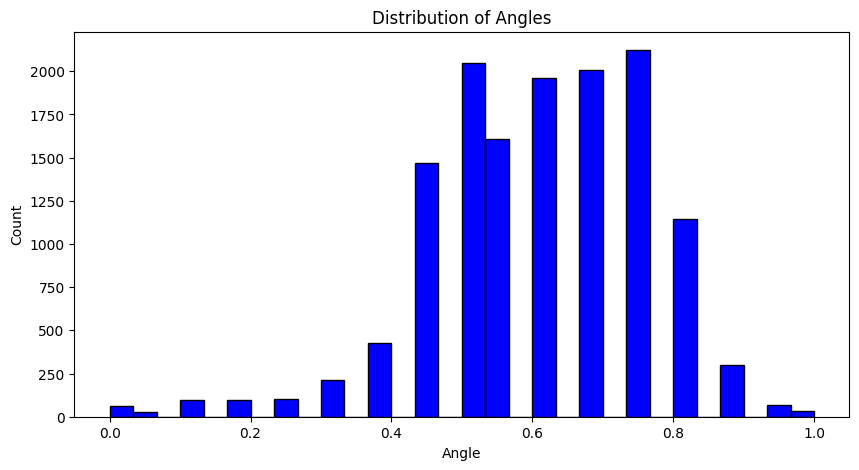

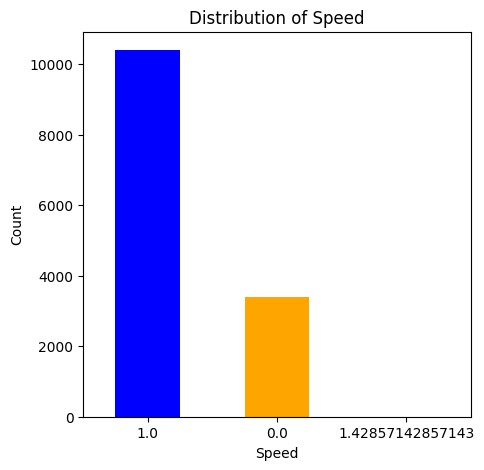

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = filtered_df.copy()
# Step 2: Plot the distribution of angles (irrespective of speed)
plt.figure(figsize=(10, 5))
plt.hist(df['angle'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Angles')
plt.xlabel('Angle')
plt.ylabel('Count')
plt.show()

# Step 3: Plot the distribution of speed
plt.figure(figsize=(5, 5))
df['speed'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Speed')
plt.xlabel('Speed')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [23]:
import pandas as pd

# Step 1: Load the dataset
df = filtered_df.copy()  # Replace with your CSV file path

# Step 2: Categorize angles into bins (0-0.5, 0.5-0.6, and >0.6)
angle_bins = pd.cut(df['angle'], bins=[0, 0.49, 0.6, float('inf')], labels=['0-0.49', '0.49-0.6', '>0.6'])

# Step 3: Count how many angles fall into each bin
angle_distribution = angle_bins.value_counts()

# Display the result
print(angle_distribution)

angle
>0.6        7641
0.49-0.6    3655
0-0.49      2437
Name: count, dtype: int64


In [24]:
import os
import cv2
import pandas as pd
from sklearn.utils import resample

# Assuming df is your DataFrame containing the data
df = filtered_df.copy()

# Ensure the directory exists for saving new images
output_dir = '/kaggle/working/balancing_data/'
os.makedirs(output_dir, exist_ok=True)

# Initialize a counter for image filenames starting from 13799
image_counter = 13799

# Step 1: Split the dataset into three bins based on the angle
df_high = df[df['angle'] > 0.6]  # Angles > 0.6
df_mid = df[(df['angle'] > 0.49) & (df['angle'] <= 0.6)]  # Angles between 0.49 and 0.6
df_low = df[df['angle'] <= 0.49]  # Angles between 0 and 0.49

# Step 2: Oversample the 0.49-0.6 bin to match the size of the >0.6 bin
df_mid_oversampled = resample(df_mid, replace=True, n_samples=len(df_high), random_state=42)

# Step 3: Augment the oversampled df_mid with new image IDs
def augment_image(row):
    global image_counter  # Use the global variable to track image numbering

    # Read the original image
    image_path = '/kaggle/input/picar-data/training_data/training_data/' + row['image_id'] + '.png'
    image = cv2.imread(image_path)
    
    if image is not None:
        # Augment the image (for example, you can add augmentation logic here)
        augmented_image = image  # For now, using the image as is
        
        # Create a new filename starting from 13799 and incrementing
        new_image_id = f'{image_counter}.png'
        new_image_path = os.path.join(output_dir, new_image_id)
        cv2.imwrite(new_image_path, augmented_image)
        
        # Increment the counter for the next image
        image_counter += 1
        
        # Return the new image_id, original angle, and original speed
        return pd.Series([new_image_id.replace('.png', ''), row['angle'], row['speed']])

# Apply augmentation to all oversampled df_mid images and assign new image IDs
df_mid_oversampled = df_mid_oversampled.apply(augment_image, axis=1)
df_mid_oversampled.columns = ['image_id', 'angle', 'speed']

# Step 4: Horizontally flip 5000 images from the >0.6 bin for the 0-0.49 bin
def flip_image_and_adjust_angle(row):
    global image_counter  # Use the global variable to track image numbering

    # Read the original image
    image_path = '/kaggle/input/picar-data/training_data/training_data/' + row['image_id'] + '.png'
    image = cv2.imread(image_path)
    
    if image is not None:
        # Flip the image horizontally
        flipped_image = cv2.flip(image, 1)
        
        # Create a new filename starting from the current image counter
        new_image_id = f'{image_counter}.png'
        new_image_path = os.path.join(output_dir, new_image_id)
        cv2.imwrite(new_image_path, flipped_image)
        
        # Adjust the angle (flipping the angle)
        new_angle = 1 - row['angle']
        
        # Increment the counter for the next image
        image_counter += 1
        
        # Return the new image_id, flipped angle, and original speed
        return pd.Series([new_image_id.replace('.png', ''), new_angle, row['speed']])

# Apply the flipping to 5000 samples from the >0.6 bin
df_flipped = df_high.sample(n=5000, random_state=42).apply(flip_image_and_adjust_angle, axis=1)
df_flipped.columns = ['image_id', 'angle', 'speed']

# Combine the flipped data with the original 0-0.49 data
df_low_augmented = pd.concat([df_low, df_flipped], ignore_index=True)

# Step 5: Combine all the resampled and augmented data into a balanced dataset
df_balanced = pd.concat([df_high, df_mid_oversampled, df_low_augmented])

# Shuffle the final balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new distribution
print(df_balanced['angle'].value_counts())

angle
0.5000    4319
0.5625    3322
0.7500    2123
0.6875    2007
0.6250    1963
0.3750    1689
0.3125    1545
0.2500    1496
0.4375    1467
0.8125    1147
0.1875     864
0.8750     301
0.1250     289
0.0000      79
0.0625      68
0.9375      65
1.0000      35
Name: count, dtype: int64


In [ ]:
import shutil
output_name = '/kaggle/working/'
directory_to_zip = '/kaggle/working/balancing_data/'

# Create a zip archive of the specified directory
shutil.make_archive(output_name, 'zip', directory_to_zip)

In [15]:
from IPython.display import FileLink
FileLink(r'balancing_data.zip')


/kaggle/working/balancing_data.zip

In [28]:
import os
import re

# Path to the image folder and the CSV file
data_dir = '/kaggle/working/balancing_data'

# Step 1: List all files in the balanced_data folder
file_list = os.listdir(data_dir)

# Step 2: Extract image IDs from file names (assuming file names are in the format: <image_id>.png)
pattern = re.compile(r'(\d+)\.png')
image_ids = [pattern.search(filename).group(1) for filename in file_list if pattern.match(filename)]

# Step 3: Load the df_balanced DataFrame containing the image_id, speed, and angle data
df_balanced = df_balanced  # Assuming df_balanced is already loaded in your workspace

# Step 4: Convert image_id to string for proper matching
df_balanced['image_id'] = df_balanced['image_id'].astype(str)

# Step 5: Filter the DataFrame to only include rows where image_id is in the image_ids list
filtered_df_balanced = df_balanced[df_balanced['image_id'].isin(image_ids)]

# Step 6: Add the full file path to the DataFrame
filtered_df_balanced['filename'] = filtered_df_balanced['image_id'].astype(str) + '.png'
filtered_df_balanced['full_path'] = filtered_df_balanced['filename'].apply(lambda x: os.path.join(data_dir, x))

# Step 7: Display the first few rows of the filtered DataFrame
print(filtered_df_balanced.tail())


      image_id   angle  speed   filename  \
22768    25623  0.3125    0.0  25623.png   
22772    25779  0.1875    1.0  25779.png   
22773    17442  0.5625    1.0  17442.png   
22774    18122  0.5000    0.0  18122.png   
22775    25236  0.1875    1.0  25236.png   

                                      full_path  
22768  /kaggle/working/balancing_data/25623.png  
22772  /kaggle/working/balancing_data/25779.png  
22773  /kaggle/working/balancing_data/17442.png  
22774  /kaggle/working/balancing_data/18122.png  
22775  /kaggle/working/balancing_data/25236.png  


/tmp/ipykernel_36/1962044886.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_balanced['filename'] = filtered_df_balanced['image_id'].astype(str) + '.png'
/tmp/ipykernel_36/1962044886.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_balanced['full_path'] = filtered_df_balanced['filename'].apply(lambda x: os.path.join(data_dir, x))


In [62]:
import pandas as pd

# Step 1: Load the dataset
df = filtered_df_balanced.copy()  # Replace with your CSV file path

# Step 2: Categorize angles into bins (0-0.5, 0.5-0.6, and >0.6)
angle_bins = pd.cut(df['angle'], bins=[0, 0.49, 0.6, float('inf')], labels=['0-0.49', '0.49-0.6', '>0.6'])

# Step 3: Count how many angles fall into each bin
angle_distribution = angle_bins.value_counts()

# Display the result
print(angle_distribution)

angle
0.49-0.6    7641
0-0.49      4981
>0.6           0
Name: count, dtype: int64


In [29]:
import os

data_dir = '/kaggle/working/balancing_data'
print(os.path.exists(data_dir))  # This should return True if the directory exists


True


In [ ]:
#import pandas as pd
#from sklearn.utils import resample

# Step 1: Load the dataset
#df = filtered_df.copy()
# Step 2: Categorize angles into bins
#df['angle_bin'] = pd.cut(df['angle'], bins=[0, 0.49, 0.6, float('inf')], labels=['0-0.5', '0.5-0.6', '>0.6'])

# Step 3: Separate data into different bins
#df_0_05 = df[df['angle_bin'] == '0-0.49']
#df_05_06 = df[df['angle_bin'] == '0.49-0.6']
#df_above_06 = df[df['angle_bin'] == '>0.6']

# Step 4: Find the minimum number of samples among the bins
#min_samples = min(len(df_0_049), len(df_049_06), len(df_above_06))

# Step 5: Undersample the bins with more samples, or oversample the bins with fewer samples
#df_0_05_balanced = resample(df_0_049, replace=True, n_samples=min_samples, random_state=42)  # Oversample or undersample
#df_05_06_balanced = resample(df_049_06, replace=True, n_samples=min_samples, random_state=42)
#df_above_06_balanced = resample(df_above_06, replace=True, n_samples=min_samples, random_state=42)

# Step 6: Combine the balanced datasets
#df_balanced = pd.concat([df_0_049_balanced, df_049_06_balanced, df_above_06_balanced])

# Step 7: Shuffle the dataset to mix the samples
#df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 8: Save the balanced dataset (optional)
#df_balanced.to_csv('/kaggle/working/training_balanced.csv', index=False)

# Display the new distribution
#print(df_balanced['angle_bin'].value_counts())

In [ ]:
print(df_balanced.head())

In [30]:
# Prepare data
X_train, X_valid, y_train, y_valid = train_test_split(filtered_df_balanced['filename'].values, 
                                                      filtered_df_balanced[['angle', 'speed']].values, 
                                                      test_size=0.2, random_state=42)

In [46]:
def my_imread(image_path):
    full_image_path = "/kaggle/working/balancing_data/" + image_path
    
    
    image = cv2.imread(full_image_path)
    
    if image is None:
        print(f"Failed to load image: {full_image_path}")  # Debugging print
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [47]:
import imgaug.augmenters as img_aug


def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

# Function for adjusting brightness
def adjust_brightness(image):
    # Increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

# Function for flipping image and adjusting steering angle
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # Randomly flip horizon
        image = cv2.flip(image, 1)
        steering_angle = 1 - steering_angle
    return image, steering_angle

# Function for panning the image
def pan_image(image):
    # Panning by shifting the image up to 10% of the width and height
    pan = img_aug.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [48]:
def img_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, _, _ = image.shape
    image = image[int(height/8):, :, :]  # Crop top part (road only)
    image = cv2.resize(image, (224, 224))  # Resize for MobileNetV3 input size
    image = preprocess_input(image)  # MobileNetV3 expects pixels in [-1, 1]
    return image

In [49]:
# Random augment function that includes panning, zoom, brightness adjustment, and flipping
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan_image(image)  # Apply panning
    if np.random.rand() < 0.5:
        image = zoom(image)  # Apply zoom
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)  # Adjust brightness
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)  # Apply horizontal flip and adjust steering angle
    return image, steering_angle

In [50]:
import numpy as np
from sklearn.utils import shuffle

def image_generator(filenames, labels, batch_size=32, augmentation_probability=0.5):
    while True:
        filenames, labels = shuffle(filenames, labels)
        for start in range(0, len(filenames), batch_size):
            end = min(start + batch_size, len(filenames))
            batch_filenames = filenames[start:end]
            batch_labels = labels[start:end]
            
            images = []
            angles = []
            speeds = []
            
            for i, filename in enumerate(batch_filenames):
                anglenorm = batch_labels[i][0]  # The normalized angle (0 to 1)
                speed = batch_labels[i][1]

                # Scale up the angle using the formula: angle = anglenorm * 80 + 50
                #angle = (anglenorm * 80) + 50
                angle = anglenorm

                image = my_imread(filename)
                
                if np.random.rand() < augmentation_probability:
                    image, angle = random_augment(image, angle)
                
                image = img_preprocess(image)
                images.append(image)
                angles.append(angle)
                speeds.append(speed)
            
            yield np.array(images), {'angle_output': np.array(angles), 'speed_output': np.array(speeds)}

In [51]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.regularizers import l2

# Example of applying L2 regularization only to some layers or with different strengths
def build_model():
    inputs = Input(shape=(224, 224, 3))
    base_model = MobileNetV3Small(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = True  # Fine-tuning some layers

    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)

    # Apply L2 regularization to some layers with different strengths
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Stronger regularization here
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)  # Weaker regularization here
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu', kernel_regularizer=None)(x)  # No regularization on this layer
    x = Dropout(0.2)(x)

    # Output layers
    angle_output = Dense(1, name='angle_output')(x)
    speed_output = Dense(1, name='speed_output')(x)

    model = Model(inputs=inputs, outputs=[angle_output, speed_output])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss={'angle_output': 'mse', 'speed_output': 'mse'},
                  metrics={'angle_output': 'mse', 'speed_output': 'mse'})
    
    return model

In [ ]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau


# Reduce learning rate when a metric has stopped improving
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [52]:
# Initialize the model
model = build_model()

In [53]:
# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobilenetV3small    │ (None, 7, 7, 576) │    939,120 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 576)       │          0 │ MobilenetV3small… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    295,424 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ angle_output        │ (None, 1)         │        129 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ speed_output        │ (None, 1)         │        129 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,399,026 (5.34 MB)

 Trainable params: 1,386,914 (5.29 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [55]:
# Training parameters
batch_size = 32
epochs = 20
train_steps = len(X_train) // batch_size
valid_steps = len(X_valid) // batch_size

In [56]:
# Create generators for training and validation data
train_gen = image_generator(X_train, y_train, batch_size=batch_size, augmentation_probability=0.5)
valid_gen = image_generator(X_valid, y_valid, batch_size=batch_size, augmentation_probability=0.0)

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_speed_angle_mobilenetv3.keras', 
                             monitor='val_loss',  # You can change this to any metric like 'val_accuracy'
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' because we want to minimize the loss
                             verbose=1)

In [58]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=valid_steps,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint]  # Add the checkpoint callback
)

Epoch 1/20


I0000 00:00:1727117057.091106     396 service.cc:145] XLA service 0x7f7a38003c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727117057.091155     396 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727117057.091159     396 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/316 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - angle_output_mse: 0.6900 - loss: 2.6412 - speed_output_mse: 1.2410   

I0000 00:00:1727117084.374292     396 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - angle_output_mse: 0.2058 - loss: 1.2973 - speed_output_mse: 0.3846
Epoch 1: val_loss improved from inf to 0.84368, saving model to best_speed_angle_mobilenetv3.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - angle_output_mse: 0.2055 - loss: 1.2966 - speed_output_mse: 0.3842 - val_angle_output_mse: 0.0207 - val_loss: 0.8437 - val_speed_output_mse: 0.1257
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - angle_output_mse: 0.0515 - loss: 0.8672 - speed_output_mse: 0.1222
Epoch 2: val_loss improved from 0.84368 to 0.76340, saving model to best_speed_angle_mobilenetv3.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - angle_output_mse: 0.0515 - loss: 0.8671 - speed_output_mse: 0.1222 - val_angle_output_mse: 0.0201 - val_loss: 0.7634 - val_speed_output_mse: 0.0623
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - angle_output_mse: 0.0367 - loss: 0.7994 - speed_output_mse: 0.0864
Epoch 3: val_loss improved from 0.76340 to 0.72823, 

In [59]:
model.save('best_speed_angle_mobilenetv3.keras')

In [61]:
from tensorflow.keras.models import load_model
import os
import cv2
import numpy as np
import pandas as pd

# Load the trained model
model = load_model('/kaggle/working/best_speed_angle_mobilenetv3.keras')

# Define the test data directory
test_data_dir = '/kaggle/input/picar-data/test_data/test_data/'

# Get a list of test image filenames
test_images = os.listdir(test_data_dir)

# Function to preprocess the image (assuming the same preprocessing used in training)
def prepare_image_for_inference(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))  # Resizing to the input size of MobileNetV3
    image = image / 127.5 - 1.0  # Normalization to [-1, 1] as used during training
    return image

# Create an empty list to store the predictions
predictions = []

# Iterate over the test images
for filename in test_images:
    image_id = os.path.splitext(filename)[0]  # Extract the image_id (without .png extension)
    image_path = os.path.join(test_data_dir, filename)

    # Preprocess the image
    image = prepare_image_for_inference(image_path)
    
    # Predict speed and angle (model expects a batch, so we need to expand dimensions)
    predictions_dict = model.predict(np.expand_dims(image, axis=0))

    # Extract the predicted angle and speed from their respective outputs
    predicted_angle = predictions_dict[0][0][0]  # Extract angle from angle_output (scaled angle)
    predicted_speed = predictions_dict[1][0][0]  # Extract speed from speed_output
    
    # Normalize the predicted angle back to range [0, 1]: anglenorm = (angle - 50) / 80
    predicted_anglenorm = predicted_angle 
    
    # Round the speed prediction: 1 if > 0.6, else 0
    predicted_speed = 1 if predicted_speed > 0.6 else 0

    # Append the prediction to the list
    predictions.append([image_id, predicted_anglenorm, predicted_speed])

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(predictions, columns=['image_id', 'angle', 'speed'])

# Sort the DataFrame by image_id (numeric sorting)
predictions_df = predictions_df.sort_values(by='image_id', key=lambda x: x.astype(int))

# Save the predictions to a CSV file
output_csv_path = '/kaggle/working/test_predictions.csv'
predictions_df.to_csv(output_csv_path, index=False)

# Display the first few rows of the CSV file to confirm
print(predictions_df.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━